# Statistical Hypothesis Testing II

In this notebook, we will implement and apply **statistical hypothesis tests** to make inferences about risks of learning algorithms.

At the start, we will compare two learning algorithms on one domain via the paired $t$-test.

Subsequently, we will compare the two learning algorithm across multiple domains via the Wilcoxon signed-rank test.

### **Table of Contents**
1. [Paired $t$-test](#paired-t-test)
2. [Wilcoxon Signed-rank Test](#wilcoxon-signed-rank-test)

In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. Paired $t$-test** <a class="anchor" id="paired-t-test"></a>

We implement the function [`t_test_paired`](../e2ml/evaluation/_paired_tests.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we check it for varying types of tests.

In [11]:
from e2ml.evaluation import t_test_paired
r_1 = np.round(stats.norm.rvs(loc=0.1, scale=0.03, size=40, random_state=0), 2)
r_2 = np.round(stats.norm.rvs(loc=0.12, scale=0.03, size=40, random_state=1), 2)
mu_0 = 0
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="right-tail")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.9256, 'The p-value must be ca. 0.9256 for the one-sided right-tail test.' 
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="left-tail")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.0744, 'The p-value must be ca. 0.0744 for the one-sided left-tail test.' 
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="two-sided")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.1487, 'The p-value must be ca. 0.1487 for the two-sided test.' 

Next, we want to check whether a *support vector classifier* (SVC) significantly outperforms a *Gaussian process classifier* (GPC) on the data set breast cancer, where we use the zero-one loss as performance measure and the paired $t$-test with $\alpha=0.01$. Design and perform the corresponding evaluation study.

t-statistic: 1.6690, p-value: 0.0695, the null hypothesis is not rejected (alpha=0.01), therefore the performances are not significantly better.


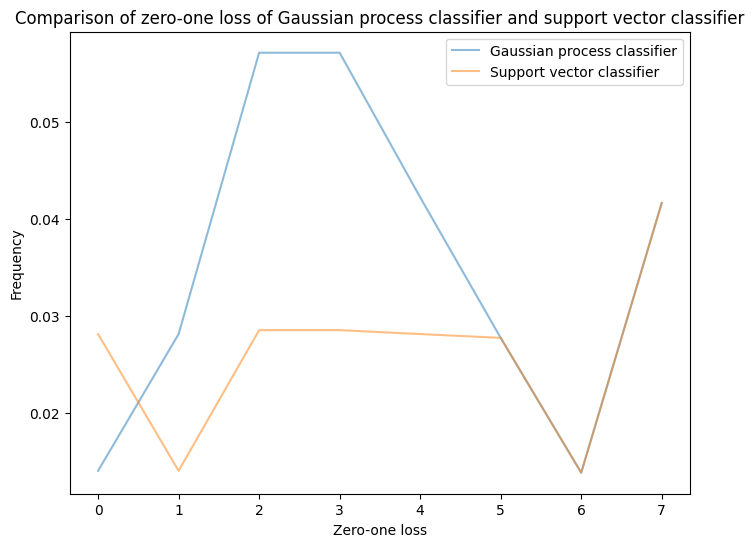

In [12]:
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import load_breast_cancer
from e2ml.evaluation import cross_validation, zero_one_loss
from e2ml.preprocessing import StandardScaler

# load data
X, y = load_breast_cancer(return_X_y=True)

# create folds
sample_indices = np.arange(len(y), dtype=np.int64)
n_folds = 10
train, test = cross_validation(sample_indices, n_folds=n_folds, y=y, random_state=42)

# prep results
risks_gpc = []
risks_svc = []

# loop through folds
for train_, test_ in zip(train, test):
    scaler = StandardScaler().fit(X[train_])
    X_train = scaler.transform(X[train_])
    X_test = scaler.transform(X[test_])
    y_train = y[train_]
    y_test = y[test_]

    # setup classifiers
    gpc = GaussianProcessClassifier(random_state=42)
    svc = SVC(random_state=42)

    # train classifier
    gpc.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    # predict on test set
    y_pred_gpc = gpc.predict(X_test)
    y_pred_svc = svc.predict(X_test)

    # compute zero-one loss
    loss_gpc = zero_one_loss(y_test, y_pred_gpc)
    loss_svc = zero_one_loss(y_test, y_pred_svc)

    # save results of fold
    """
    risks_gpc.append(gpc.score(X_test, y_test))
    risks_svc.append(svc.score(X_test, y_test))
    """
    risks_gpc.append(loss_gpc)
    risks_svc.append(loss_svc)

# perform paired t-test to compare performances
alpha = 0.01
t_statistic, p = t_test_paired(sample_data_1=risks_gpc, sample_data_2=risks_svc, mu_0=0, test_type="right-tail")

print(f"t-statistic: {t_statistic:.4f}, p-value: {p:.4f}, the null hypothesis is {'' if p <= alpha else 'not '}rejected (alpha={alpha}), therefore the performances are {'' if p <= alpha else 'not '}significantly better.")

# plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(risks_gpc, label="Gaussian process classifier", alpha=0.5)
ax.plot(risks_svc, label="Support vector classifier", alpha=0.5)
ax.set_xlabel("Zero-one loss")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of zero-one loss of Gaussian process classifier and support vector classifier")
ax.legend()
plt.show()

#### **Questions:**
1. (a) What are possible issues of your conducted evaluation study?
   
   TODO
   TODO

### **2. Wilcoxon Signed-rank Test** <a class="anchor" id="wilcoxon-signed-rank-test"></a>

We implement the function [`wilcoxon_signed_rank_test`](../e2ml/evaluation/_paired_tests.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we check it for varying types of tests.

In [13]:
from e2ml.evaluation import wilcoxon_signed_rank_test

# Test for exact computation.
r_1 = stats.norm.rvs(loc=0.1, scale=0.03, size=10, random_state=0)
r_2 = stats.norm.rvs(loc=0.15, scale=0.03, size=10, random_state=1)
d = r_2 - r_1
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="right-tail")
assert w_statistic == 47 , f'The positive rank sum statistic must be 47. It is {w_statistic}.' 
assert np.round(p, 4) == 0.0244, f'The p-value must be ca. 0.0244 for the one-sided right-tail test. It is {p}.'
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="left-tail")
assert w_statistic == 47 , f'The positive rank sum statistic must be 47. It is {w_statistic}.' 
assert np.round(p, 4) == 0.9814, f'The p-value must be ca. 0.9814 for the one-sided left-tail test. It is {p}.' 
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="two-sided")
assert w_statistic == 47 , f'The positive rank sum statistic must be 47. It is {w_statistic}.' 
assert np.round(p, 4) == 0.0488, f'The p-value must be ca. 0.0488 for the two-sided test. It is {p}.' 

# Test for approximative computation.
r_1 = stats.norm.rvs(loc=2, scale=0.3, size=100, random_state=0)
r_2 = stats.norm.rvs(loc=2.1, scale=0.3, size=100, random_state=1)
d = r_2 - r_1
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="right-tail")
assert w_statistic == 3303 , f'The positive rank sum statistic must be 3303. It is {w_statistic}.' 
assert np.round(p, 4) == 0.0037, f'The p-value must be ca. 0.0037 for the one-sided right-tail test. It is {p}.' 
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="left-tail")
assert w_statistic == 3303 , f'The positive rank sum statistic must be 3303. It is {w_statistic}.' 
assert np.round(p, 4) == 0.9963, f'The p-value must be ca. 0.9963 for the one-sided left-tail test. It is {p}.' 
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="two-sided")
assert w_statistic == 3303 , f'The positive rank sum statistic must be 3303. It is {w_statistic}.' 
assert np.round(p, 4) == 0.0075, f'The p-value must be ca. 0.0075 for the two-sided test. It is {p}.' 

Next, we want to check whether a *support vector classifier* (SVC) significantly outperforms a *Gaussian process classifier* (GPC) on ten artificially generated data sets, where we use the zero-one loss as performance measure and the paired $t$-test with $\alpha=0.01$. Design and perform the corresponding evaluation study.

t-statistic: 55.0000, p-value: 0.0010, the null hypothesis is rejected (alpha=0.01), therefore the performances are significantly better.


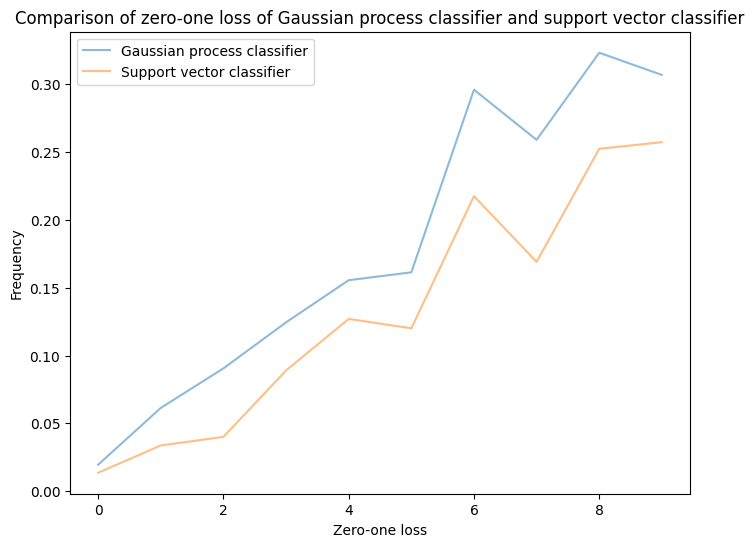

In [18]:
from sklearn.datasets import make_classification

# Create 10 articial data sets.
data_sets = []
n_classes_list = np.arange(2, 12)
for n_classes in n_classes_list:
    X, y = make_classification(
        n_samples=500, n_classes=n_classes, class_sep=2, n_informative=10, random_state=n_classes
    )
    data_sets.append((X, y))

# create folds
sample_indices = np.arange(len(data_sets[0][1]), dtype=np.int64)
n_folds = 10
train, test = cross_validation(sample_indices, n_folds=n_folds, y=y, random_state=42)

# prep results
risks_gpc = []
risks_svc = []

# loop through folds
for X, y in data_sets:
    risks_gpc.append([])
    risks_svc.append([])
    for train_, test_ in zip(train, test):
        scaler = StandardScaler().fit(X[train_])
        X_train = scaler.transform(X[train_])
        X_test = scaler.transform(X[test_])
        y_train = y[train_]
        y_test = y[test_]

        # setup classifiers
        gpc = GaussianProcessClassifier(random_state=42)
        svc = SVC(random_state=42)

        # train classifier
        gpc.fit(X_train, y_train)
        svc.fit(X_train, y_train)

        # predict on test set
        y_pred_gpc = gpc.predict(X_test)
        y_pred_svc = svc.predict(X_test)

        # compute zero-one loss
        loss_gpc = zero_one_loss(y_test, y_pred_gpc)
        loss_svc = zero_one_loss(y_test, y_pred_svc)

        # save results of fold
        """
        risks_gpc.append(gpc.score(X_test, y_test))
        risks_svc.append(svc.score(X_test, y_test))
        """
        risks_gpc[-1].append(loss_gpc)
        risks_svc[-1].append(loss_svc)

risks_gpc = np.mean(risks_gpc, axis=1)
risks_svc = np.mean(risks_svc, axis=1)

# perform paired t-test to compare performances
alpha = 0.01
t_statistic, p = wilcoxon_signed_rank_test(sample_data_1=risks_gpc, sample_data_2=risks_svc, test_type="right-tail")

print(f"t-statistic: {t_statistic:.4f}, p-value: {p:.4f}, the null hypothesis is {'' if p <= alpha else 'not '}rejected (alpha={alpha}), therefore the performances are {'' if p <= alpha else 'not '}significantly better.")

# plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(risks_gpc, label="Gaussian process classifier", alpha=0.5)
ax.plot(risks_svc, label="Support vector classifier", alpha=0.5)
ax.set_xlabel("Zero-one loss")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of zero-one loss of Gaussian process classifier and support vector classifier")
ax.legend()
plt.show()

#### **Questions:**
2. (a) What are possible issues of your conducted evaluation study?
   
   TODO
   TODO

Wenn modelle sehr langsam trainiren -> nur auf einem datensatz trainieren (mit train/test split) und dann auf den anderen datensätzen testen? <br/>
=> Wenn datensätze aus gelicher quelle dann ja (so als wäre es ein großer datensatz und der trainings anteil wäre sehr klein) -> evtl nicht so aussagekräftig <br/>
=> Smarter wäre training daten aus den datensätzen zu mischen und dann auf den anderen datensätzen testen <br/>
=> Wenn domain shift dann nicht so gut <br/>
=> Am Ende erwähnen, dass limitierung vor liegt. <br/>